<h1 align="center"><font size="7" face="arial" color="#73ACCD">Hands-On: TVB Clinical Application</font></h1>
<h2 align="center"><font size="6" face="arial" color="#73ACCD">Perform an epilepsy surgery in brain patient</font></h2>

<br>
<h2 align="center"><font size="5" face="arial">August 31, 2019</font></h2>

<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Julie Courtiol</font></span></h3>
<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial">Charité Universitätsmedizin Berlin, Dept of Neurol, Brain Simulation Section, Berlin, Germany</font></span></h3>

<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial"><a href="mailto:julie.courtiol@charite.de">julie.courtiol@charite.de</a></font></span></h3>

<br><h4><span style="font-weight:normal"><font size="3" face="arial"><b>Note to the users: If you are planning to create your own exploratory examples, please do not modify the original document, but create your personal copy that you can can edit.</b></font></span></h4>

<h1><font size="6" face="arial" color="#386766">Context</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
<ul>
<li><b>Epilepsy</b> is one of the most common neurological disorder that is defined by the occurrence of repetitive unexpected seizures. These epileptic seizures, characterized as abnormal synchronization of neural activities, originate in a specific set of brain regions, known as the <b>Epileptique Zone (EZ)</b>, and propagate to other regions, the <b>Propagation Zone (PZ)</b>, through inter-regional structural interactions, i.e., individual brain connectome, and produce various ictal symptoms depending on the recruited brain regions.</li><br>
    
<li>Approximately 30% of patients suffering from focal seizures are refractory to medication, hence <b>surgical intervention</b>, which consists in the removal of the EZ, is considered as an alternative treatment.</li><br>
</ul></font></div></p>

<br><h1><font size="6" face="arial" color="#386766">Objectives</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman">The main goal of this hands-on is to provide a clear understanding of <b>how we can reproduce clinically relevant scenarios</b> such as:
<ul>
<li>the modelisation of the <b>propagation of an epileptic seizure</b> in a human brain,</li> 
<li>the <b>surgical resection</b> of the Epileptogenic Zone,</li> 
<li>and the <b>electrical stimulation</b> of a brain region that can trigger a seizure.</li> 
</ul></font></div></p>

<br><h1><font size="6" face="arial" color="#386766">How to do it with TVB?</font></h1> 

---

<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we need to do, is to import the necessary TVB modules and some additional Python packages to perform the simulation and visualize our results.</font></div></p>

In [1]:
!pip install -U tvb-library

!pip uninstall -y tvb-data
!wget https://zenodo.org/record/3688773/files/tvb-data.zip?download=1 -O $HOME/tvb_data.zip; \
    rm -rf $HOME/tvb_data; mkdir $HOME/tvb_data; unzip $HOME/tvb_data.zip -d $HOME/tvb_data; rm $HOME/tvb_data.zip; \
    cd $HOME/tvb_data; python setup.py develop

Requirement already up-to-date: tvb-library in /opt/app-root/lib/python3.6/site-packages (2.0.9)
You should consider upgrading via the '/opt/app-root/bin/python3 -m pip install --upgrade pip' command.
--2020-10-19 12:30:50--  https://zenodo.org/record/3688773/files/tvb-data.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355927948 (339M) [application/octet-stream]
Saving to: ‘/opt/app-root/src/tvb_data.zip’

100%[======================================>] 355,927,948 46.1MB/s   in 6.9s   

2020-10-19 12:30:58 (49.0 MB/s) - ‘/opt/app-root/src/tvb_data.zip’ saved [355927948/355927948]

Archive:  /opt/app-root/src/tvb_data.zip
  inflating: /opt/app-root/src/tvb_data/Jenkinsfile  
  inflating: /opt/app-root/src/tvb_data/LICENSE  
  inflating: /opt/app-root/src/tvb_data/MANIFEST.in  
  inflating: /opt/app-root/src/tvb_data/README.rst  
  inflating: /o

In [2]:
# Online visualization.
%pylab nbagg

# Import tvb packages.
from tvb.simulator.lab import *
import tvb.datatypes.projections as projections

# Import a bunch of Python stuff to ease command line usage.
from os.path import join
import numpy as np
import time as tm
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

<h1><font size="6" face="arial" color="black">1. Build a virtual epileptic patient</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">In the following, we will model a random patient suffering from a <b>bilateral temporal lobe epilepsy (TLE)</b> using the Default TVB Subject dataset.</font></div></p><br>

<p><div style="text-align: justify"><font size="4.5" face="time roman">First, we need to download from the Collab Storage area the relevant files, and make them accessible for the notebook runtime environment.</font></div></p> 

<br><p><div style="text-align: justify"><font size="4.5" face="time roman">The basic simulation of TVB consists of <b>5 main components</b>. Each of these components is an object within TVB:</font></div></p>

<h2><font size="5"face="arial" color="black"> 1.1 Anatomical Structural Connectivity</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We start with loading and visualizing the structural connectivity matrix of the patient.</font></div></p>

WARNING  File 'hemispheres' not found in ZIP.


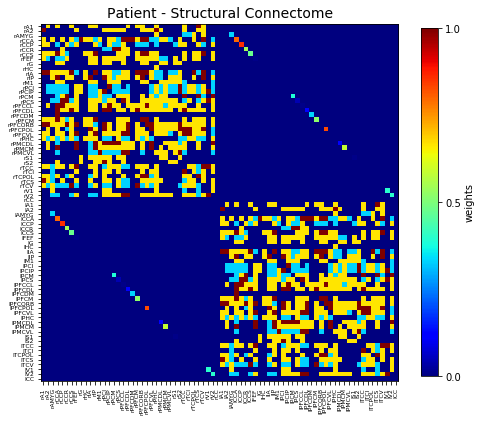

In [4]:
# Initialise a Connectivity.
con = connectivity.Connectivity.from_file()       
nregions = len(con.areas)                                  #number of regions
con.weights = con.weights - con.weights * np.eye(nregions) #remove self-connections
con.weights = con.weights / np.abs(con.weights.max())      #normalize
con.speed = np.array(np.inf)                               #set the conduction speed to infinity (no time delays)
con.configure()

# Visualization.
figure(figsize=(8,8))
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('Patient - Structural Connectome', fontsize=14)
cb=colorbar(shrink=0.8, ticks=[0, .5, 1])
cb.set_label('weights')
xticks(range(0, nregions), con.region_labels, fontsize=6, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=6)
show()

<h2><font size="5" face="arial" color="black"> 1.2 Model</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">In order to model epilepsy, we choose the <b>Epileptor</b> which is a phenomenological neural mass model able to realistically reproduce <b>epileptic seizure dynamics</b> such as recorded with intracranial EEG electrodes (see <b>Jirsa et al., Brain 2014</b>):</font></div></p>

\begin{eqnarray}
    \dot{x}_{1} &=& y_{1} - f_{1}(x_{1}, x_{2}) - z + I_{ext_{1}}\\
    \dot{y}_{1} &=& 1 - 5x_{1}^{2} - y_{1}\\
    \dot{z} &=& \dfrac{1}{\tau_{0}} \ (4 (x_{1} - \color{blue}{x_{0}}) - z)\\
    \dot{x}_{2} &=& - y_{2} + x_{2} - x_{2}^{3} + I_{ext_{2}} + 0.002g(x_{1}) - 0.3 (z - 3.5)\\
    \dot{y}_{2} &=& \dfrac{1}{\tau_{2}} \ (-y_{2} + f_{2}(x_{2}))\\
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">where $\tau_{0}=2857$, $I_{ext_{1}}=3.1$, $I_{ext_{2}}=0.45$. The parameter $\pmb{x_{0}}$ controls the degree of <b>epileptogenicity</b> (or excitability) of the node:

<br>
<ul><li>if $\pmb{x_{0} \geqslant x_{0, c}}$, the Epileptor can trigger seizures and is said <b>epileptogenic</b>,</li>

<br><li>inversely, if $\pmb{x_{0} < x_{0, c}}$, the Epileptor does not trigger seizure and is said <b>not epileptogenic</b> (or in its "healthy" equilibrium state).</li></ul>


<br>See equations page 8 in Jirsa et al. (2014) for more details on the model.</font></div></p>

In [5]:
# Initialise a Model.
epi = models.Epileptor(Ks=np.array(1.), r=np.array(0.00015)) # in Jirsa et al. (2014): r = 1/ \tau_0

# Set initial conditions in fixed point.
epi.state_variable_range["x1"] = [-5, -3]
epi.state_variable_range["y1"] = [-50, -50]
epi.state_variable_range["z"] = [4., 6.]
epi.state_variable_range["x2"] = [-1.1, 1.1]
epi.state_variable_range["y2"] = [0.001, 0.01]

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can refine the network pathology of the patient by including the clinical hypothesis about its <b>Epileptogenic Network</b>. To this end, we define a <b>spatial map of epileptogenicity</b> where each network's node <i>i</i> is characterized by an excitability value $\pmb{x_{0,i}}$, which quantifies the ability of the node to trigger a seizure. 
<br>We set:
<ul>
<li>the hippocampus (rHC, region 9 and lHC, region 47) as well as the amydala (rAMYG, region 2 and lAMYG, region 40)
as part of the <b>Epileptogenic Zone (EZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-1.4</b> for the rHC and <b>-1.6</b> for the lHC and l-rAMYG,</li> 
<li>we also add two lesser epileptogenic regions: the parahippocampal (lPHC, region 62) and the temporal pole (lTPOL, region 70) as part of the <b>Propagation Zone (PZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-1.7</b> and <b>-1.8</b>, respectively,</li>
<li>and all the other regions (or <b>Non-Involved Zone, NIZ</b>) are set to <b>-2.6</b>.</li>
</ul>

In [6]:
# Define a heatmap.
epi.x0 = np.ones(nregions) * (-2.6)           #NIZ
epi.x0[[9]] = np.ones((1)) * (-1.4)           #EZ 
epi.x0[[47, 2, 40]] = np.ones((3)) * (-1.6)   #EZ 
epi.x0[[62]] = np.ones((1)) * (-1.7)          #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.8)          #PZ 

<h2><font size="5"face="arial" color="black"> 2.3 Coupling function</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We couple the Epileptors by <b>permittivity coupling</b> (see Proix et al., 2014), which quantifies the influence of neuronal fast discharges $x_{1,j}$ of a remote region $j$ on the local slow permittivity variable $z_{i}$ of region $i$ via a linear <b>difference coupling</b> function, allowing the spread of the seizure through the network by recruiting regions that are not in the EZ.</font></div></p>

\begin{eqnarray}
    \dot{x}_{1,i} &=& y_{1,i} - f_{1}(x_{1,i}, x_{2,i}) - z_{i} + I_{ext_{1}}\\
    \dot{y}_{1,i} &=& 1 - 5x_{1,i}^{2} - y_{1,i}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (4 (x_{1,i} - x_{0,i}) - z_{i} \color{red}{- K_{s} * G \ \sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i}))}\\
    \dot{x}_{2,i} &=& - y_{2,i} + x_{2,i} - x_{2,i}^{3} + I_{ext_{2}} + 0.002g(x_{1,i}) - 0.3 (z_{i} - 3.5)\\
    \dot{y}_{2,i} &=& \dfrac{1}{\tau_{2}} \ (-y_{2,i} + f_{2}(x_{2,i}))\\
\end{eqnarray}

In [7]:
# Initialise a Coupling function.
G = np.array(-0.25)      #global (long-range) coupling strength
con_coupling = coupling.Difference(a=G)

<h2><font size="5"face="arial" color="black"> 2.4 Integrator</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We employ a standard <b>Heun method</b> with an integration time step of <b>0.05</b>. <b>Additive white Gaussian noise</b> is introduced in the state-variables $\pmb{x_{2,i}}$ and $\pmb{y_{2,i}}$ with 0 mean and variance <b>0.00025</b>.</font></div></p>

In [8]:
# Initialise an Integrator scheme.
dt = 0.05               #integration steps [ms]
nsigma = 0.00025        #standard deviation of the noise

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma, nsigma, 0.])) 
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

<h2><font size="5"face="arial" color="black"> 2.5 Monitors</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Here, we will select (1) a simple data reduction monitor and (2) a biophysical measurement process to relate the simulated neural activity to recent epilepsy studies: 

<ol type="1">
<li>the <b>TemporalAverage</b> monitor averages over a time window of length <i>period</i> returning one time point every <i>period</i> ms,</li>
<li>the <b>iEEG</b> monitor generates SEEG recordings.</li>
</ol>
</font></div></p>

In [9]:
# Initialise some Monitors with period in physical time.
#Temporal Average
mon_tavg = monitors.TemporalAverage(period=1) #in ms

#SEEG
#Load the default region mapping
#rm = region_mapping.RegionMapping.from_file("regionMapping_16k_76.txt")

#mon_seeg = monitors.iEEG.from_file(
            #sensors_fname="seeg_588.txt",
            #projection_fname="projection_seeg_588_surface_16k.npy",
            #region_mapping=rm,
            #period=1.)

#what_to_watch = (mon_tavg, mon_seeg)

***

<h1 align="center"><font size="6"face="arial" color="black">Go! Simulate</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can then configure and run the <b>Simulator</b>.</font></div></p>

In [10]:
# Initialise the Simulator.
sim = simulator.Simulator(connectivity=con,
                          conduction_speed=np.float(con.speed),
                          model=epi,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[mon_tavg])#what_to_watch)

sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 4a948c32-0d87-4e19-80cb-df139b0cfa82
coupling,Difference gid: f5edcd2b-2958-4c4d-980c-ffd01d748ddf
gid,UUID('1f0441c2-e398-4942-80b0-2e0d9f9bbac2')
initial_conditions,None
integrator,HeunStochastic gid: 9e56f005-cafc-47b9-87ce-bceaa588c08e
model,Epileptor gid: 517cca4b-9c85-4e83-b6a3-1d759f163f1f
monitors,[]
simulation_length,1000.0


In [11]:
# Starting simulation.
print("Starting simulation...")
tic = tm.time()
#(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=10000) 
(ttavg, tavg), = sim.run(simulation_length=10000) 

# Finished simulation. 
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for100.26957058906555


***

<h1 align="center"><font size="6"face="arial" color="black">Visualize our simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">And finally, we can look at the results of our simulation in terms of time series:</font></div></p>

In [12]:
# Normalize the time series to have nice plots.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)
#seeg /= (np.max(seeg,0) - np.min(seeg, 0))
#seeg -= np.mean(seeg, 0)

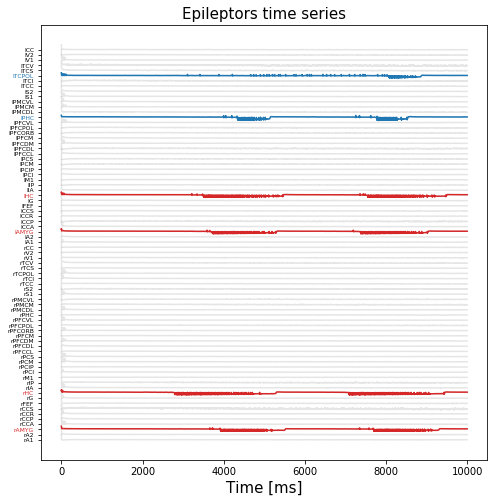

In [13]:
# Plot source activity time series.
fig, ax  = subplots(figsize=(8,8))

ax.plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'k', alpha=0.1)
title('Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)

EZs = [9, 47, 2, 40]
for iez, ez in enumerate(EZs):
    ax.plot(ttavg[:], tavg[:, 0, EZs[iez], 0] + EZs[iez], 'C3')
    ax.get_yticklabels()[EZs[iez]].set_color('C3')

PZs = [62, 70]
for ipz, pz in enumerate(PZs):
    ax.plot(ttavg[:], tavg[:, 0, PZs[ipz], 0] + PZs[ipz], 'C0')
    ax.get_yticklabels()[PZs[ipz]].set_color('C0')
    
show()

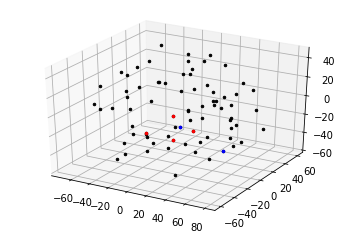

In [15]:
# Visualize patient's electrodes.
figure()
ax = subplot(111, projection='3d')

#ROI centers as black circles
x, y, z = con.centres.T
ax.plot(x, y, z, 'ko', markersize=2.5)

x_ez, y_ez, z_ez = con.centres[EZs].T
ax.plot(x_ez, y_ez, z_ez, 'ro', markersize=2.5)
x_pz, y_pz, z_pz = con.centres[PZs].T
ax.plot(x_pz, y_pz, z_pz, 'bo', markersize=2.5)

#SEEG sensors as blue circles
# contacts = np.r_[np.arange(27, 36), np.arange(321, 330), #B(rHC) - B'(lHC)
#                  np.arange(36, 45), np.arange(330, 339), #C(rHC) - C'(lHC)
#                  np.arange(18, 27), np.arange(312, 321), #NA(rA) - NA'(lA)
#                  np.arange(339, 348), #GPH'(lPHC)
#                  np.arange(294, 303), #TP'(lTP)
#                  np.arange(303, 312) # TB' (lTl basalis)
#                   ]
# x, y, z = mon_seeg.sensors.locations[contacts].T
# ax.plot(x, y, z, 'co', markersize=2.5)

# #Plot boundary surface
# face = surfaces.FaceSurface.from_file(os.path.join(datadir, "face_8614.zip"))
# face.configure()

# surf=surfaces.Surface.from_file(os.path.join(datadir, "cortex_16384.zip"))
# surf.configure()

# x, y, z = face.vertices.T
# ax.plot_trisurf(x, y, z, triangles=face.triangles, alpha=0.1, edgecolor='none')

# x, y, z = surf.vertices.T
# ax.plot_trisurf(x, y, z, triangles=surf.triangles, alpha=0.1, edgecolor='none')

# #Set rotation angle to 30 degrees
# ax.view_init(elev=10, azim=-40)

# show()

In [15]:
# Plot the selected SEEG sensors recordings.
# figure(figsize=(10,10))
# plot(tseeg[:], seeg[:, 0, contacts, 0] + np.r_[:len(contacts)], 'C0')
# yticks(np.r_[:len(contacts)], mon_seeg.sensors.labels[contacts], fontsize=6)
# title('SEEG', fontsize=15)
# xlabel('Time [ms]', fontsize=15)
# show()

<h1><font size="6" face="arial" color="black">2. Modeling epilepsy surgery</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">Epilepsy surgery is used for around 20% of patients whose seizures are drug-resistant. We will simulate the hypothetic case of a <b>surgical resection of the Epileptogenic Zone</b>.</font></div></p><br>

<h3 align="left"><font size="5"face="arial" color="black">2.1 Resection</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We set all the <b>connections to the Epileptogenic Zone to 0</b> in the connectivity matrix. The resection of the Epileptogenic Network is not complete, will it be enough to prevent seizures?</font></div></p>

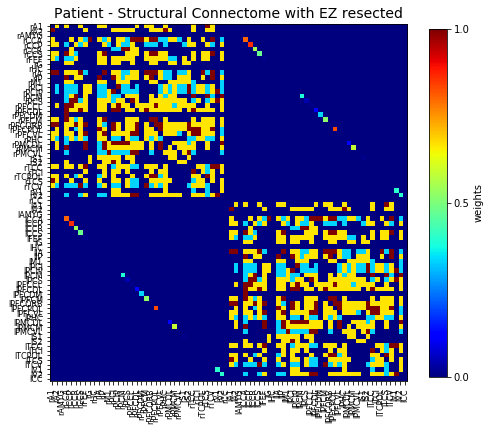

In [16]:
# All the incoming and outcoming connections of the resected regions are removed:
con.weights[:, [9, 47, 2, 40]] = 0.
con.weights[[9, 47, 2, 40], :] = 0.
con.configure()

# Visualization of the resected connectome.
figure(figsize=(8,8))
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('Patient - Structural Connectome with EZ resected', fontsize=14)
cb=colorbar(shrink=0.8, ticks=[0, 0.5, 1])
cb.set_label('weights')
xticks(range(0, nregions), con.region_labels, fontsize=8, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=8)

show()

<h3 align="left"><font size="5"face="arial" color="black">2.2 Simulate</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can now relaunch our first simulation, taking care of replacing the dynamic of the <b>EZ by a stable node</b>, as if the region was resected. The rest of the model is set as before, but we only use a time average monitor.</font></div></p>

In [17]:
# Initialise the Model.
epi = models.Epileptor(Ks=np.array(1.), r=np.array(0.00015))

# Define heatmap.
epi.x0 = np.ones(nregions) * (-2.6)       #NEZ
epi.x0[[62]] = np.ones((1)) * (-1.78)     #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.81)     #PZ 

# Set initial conditions.
epi.state_variable_range["x1"] = [-5, -3]
epi.state_variable_range["y1"] = [-50, -50]
epi.state_variable_range["z"] = [4., 6.]
epi.state_variable_range["x2"] = [-1.1, 1.1]
epi.state_variable_range["y2"] = [0.001, 0.01]

In [18]:
# Initialise the Simulator.
sim = simulator.Simulator(connectivity=con,
                          conduction_speed=np.float(con.speed),
                          model=epi,
                          coupling=coupling.Difference(a=G),
                          integrator=heunint,
                          monitors=[mon_tavg])

sim.configure()

  ERROR  Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)


,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 4a948c32-0d87-4e19-80cb-df139b0cfa82
coupling,Difference gid: 372a5cd4-b239-417a-8d94-4803e3852a4a
gid,UUID('33e98e2a-031f-4177-ac38-bc0beb887257')
initial_conditions,None
integrator,HeunStochastic gid: 9e56f005-cafc-47b9-87ce-bceaa588c08e
model,Epileptor gid: 92982978-1447-4f51-bdc9-fa572a98c9e1
monitors,[]
simulation_length,1000.0


In [19]:
# Starting simulation
print("Starting simulation...")
tic = tm.time()

(ttavg, tavg), = sim.run(simulation_length=10000)

# Finished simulation. 
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for99.35183882713318


<h3 align="left"><font size="5"face="arial" color="black">2.3 Visualize</font></h3>

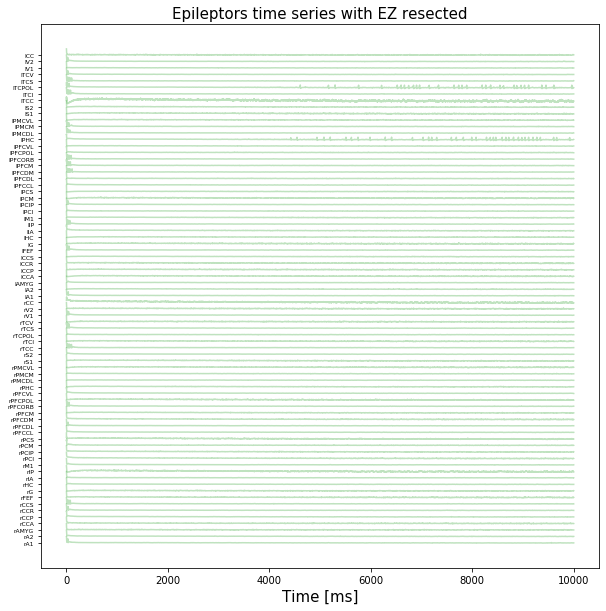

In [20]:
# Normalize the time series to have nice plots.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)

# Plot time series.
figure(figsize=(10,10))
plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'C2', alpha=0.3)
title('Epileptors time series with EZ resected', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)
show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">As you can see, no seizure is triggered anymore.</font></div></p>

<h1><font size="6" face="arial" color="#73ACCD">That is all folks</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">We hope this has been a useful tutorial and welcome any comments or questions.</font></div></p>

<br><p><div style="text-align: justify"><font size="4.5" face="time roman"><u>References</u></font></div></p>
* Jirsa et al., 2014: 

Jirsa, V. K.; Stacey, W. C.; Quilichini, P. P.; Ivanov, A. I.; Bernard, C. <b>On the nature of seizure dynamics</b>. <i>Brain</i>, 2014; 137: 2210–30.

* Proix et al., 2014:

Proix, T; Bartolomei, F.; Chauvel, P.; Bernard, C.; Jirsa, V. K. <b>Permittivity coupling across brain regions determines seizure recruitment in partial epilepsy</b>. <i>J of Neurosci</i>, 2014; 34(45):15009 –15021.